### 1 background

This is a AB testing for product feature change analysis.

### 2 data source

* The data in test.xlsx file is for testing whether the product feature makes a significant change;
* The data in city.xlsx is for exploration analysis identifying operation issues in certain city. 

* The fields in datasets are as below
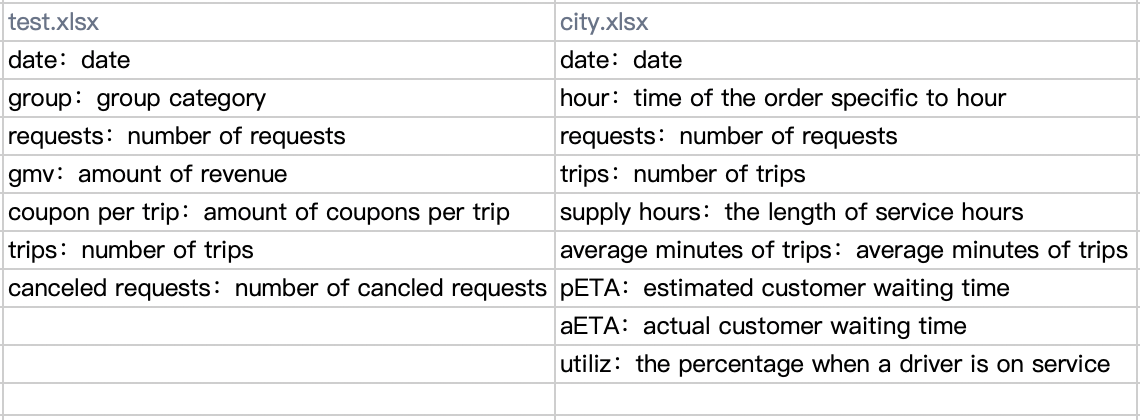

## 一  AB Testing Analysis

### 1 data import

In [2]:
#A/B testing data import

import pandas as pd

test = pd.read_excel('/Users/minyan/Desktop/Python Project/didi ab testing/test.xlsx')
test.head()

,date,group,requests,gmv,coupon per trip,trips,canceled requests
0,2019-01-01,control,30,7486.620,1.069746,24,1
1,2019-01-02,control,152,38301.575,1.044199,121,8
2,2019-01-03,control,267,67768.425,1.032276,215,14
3,2019-01-04,control,369,94992.900,1.028196,298,19
4,2019-01-05,control,478,123236.875,1.011807,390,24


### 2 calculate ROI

In [3]:
#calculate ROI

test['ROI']=test['gmv']/(test['coupon per trip']*test['trips'])
test.head()

,date,group,requests,gmv,coupon per trip,trips,canceled requests,ROI
0,2019-01-01,control,30,7486.620,1.069746,24,1,291.604269
1,2019-01-02,control,152,38301.575,1.044199,121,8,303.143166
2,2019-01-03,control,267,67768.425,1.032276,215,14,305.346684
3,2019-01-04,control,369,94992.900,1.028196,298,19,310.026761
4,2019-01-05,control,478,123236.875,1.011807,390,24,312.304607


# Solution 1: parameter-based AB testing

### 3 requests

#### 3.1 requests: test for variance 

1. The variances of requests for a, b groups are as c1, c2

2. Null hypotheisis H0：c1=c2；alternative hypothesis：H1：c1≠c2

3. alpha = 0.05

In [4]:
#test whether requests datasets between group a,b have equal variance: levene test

requests_A=test[test.group=='control'].requests
requests_B=test[test.group=='experiment'].requests

import scipy.stats as st
st.levene(requests_A,requests_B)

LeveneResult(statistic=0.014685075667736849, pvalue=0.903980667108546)

* p-value > 0.05. We can't reject null hypothesis.

#### 3.2 requests: test for mean value

1. Use paired t-test.

2. The mean values of requests for group a, b are as u1, u2.

3. Null hypothesis H0：u1=u2; alternative hypothesis：H1：u1≠u2.

4. alpha = 0.05

In [5]:
#Paired t-test 

st.ttest_rel(requests_A,requests_B)

Ttest_relResult(statistic=1.6436140982479508, pvalue=0.11143970454099936)

* p-value > 0.05. We can't reject null hypothesis.

### 4 gmv

#### 4.1 gmv for variance

In [7]:
#test whether gmv datasets between group a,b have equal variance: levene test

gmv_A=test[test.group=='control'].gmv
gmv_B=test[test.group=='experiment'].gmv

st.levene(gmv_A,gmv_B)

LeveneResult(statistic=0.02865341299111212, pvalue=0.8661917430097603)

* p-value >0.05. We can't reject null hupothesis.

#### 4.2 gmv: test for mean value

In [7]:
#Paired t-test 
st.ttest_rel(gmv_A,gmv_B)

Ttest_relResult(statistic=4.247583846321442, pvalue=0.00021564303983362577)

* p-value<0.05，Reject null hypothesis. Mean value of GMV between group a,b s significnatly differnt.

### 5 ROI

#### 5.1 ROI: test for variance 

In [8]:
#test whether ROI datasets between group a,b have equal variance: levene test

ROI_A=test[test.group=='control'].ROI
ROI_B=test[test.group=='experiment'].ROI

st.levene(ROI_A,ROI_B)

LeveneResult(statistic=0.10363884745479335, pvalue=0.7487044961896305)

* p-value>0.05. Reject null hypothesis.

#### 5.2 ROI: test for mean value

In [9]:
#paired t-test
st.ttest_rel(ROI_A,ROI_B)

Ttest_relResult(statistic=10.305504459268173, pvalue=4.93261342734923e-11)

* p-value<0.05. Reject null hypothesis. The mean value of ROI between group a,b is significnatly different.

# Solution 2 : simulation for AB testing

### 6 Requests

In [17]:
import random

In [18]:
#calculate the mean difference
re_diff=test[test['group']== "control"]['requests'].mean()-test[test['group']== "experiment"]['requests'].mean()
re_diff

7.41379310344837

shufflaed label      control   experiment
requests         2089.896552  2002.551724
requests         2232.724138  1859.724138
requests         1897.862069  2194.586207
requests         2400.620690  1691.827586
requests         1871.137931  2221.310345
...                      ...          ...
requests         2064.310345  2028.137931
requests         1912.965517  2179.482759
requests         1902.172414  2190.275862
requests         1947.068966  2145.379310
requests         2122.827586  1969.620690

[1000 rows x 2 columns]


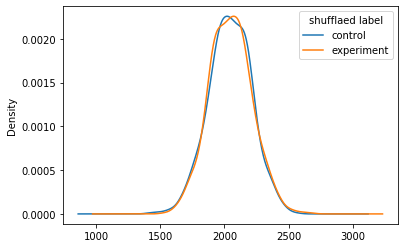

In [31]:
#create a list with shuffling means for each AB-group(shuffle the labels of group field)
requests=[]
re = test['group'].values.tolist()
#convert test['group'] to a list to apply random.shuffle()methods
#methods and implementatin as below
#re = test['group'].values.tolist()
#random.shuffle(re)
#print(re)

for i in range(1000):
    random.shuffle(re)
    test['shufflaed label']=re
    requests_mean=test.groupby('shufflaed label')['requests'].mean()
    requests.append(requests_mean)
    
#transform the list to a Dataframe
requests=pd.DataFrame(requests)
print(requests)

# A kernel Density estimate plot of the boostrap distributiona
requests.plot(kind='density')




Probablity that difference is greater than observed difference : 0.342


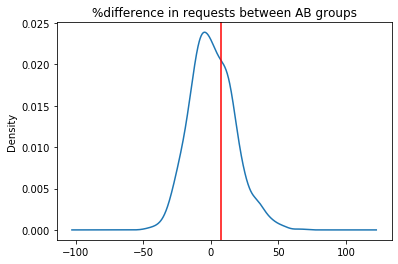

In [34]:
#add a column with the difference between AB group
requests['diff'] = (requests.control - requests.experiment)/requests.experiment*100

#plot the bootstrap % difference
ax = requests['diff'].plot(kind = 'density')
ax.set_title('%difference in requests between AB groups')
ax.axvline(x=p_diff, color= 'r')

#calculate the probablity that 1-day retention is greater when the gate is at level 30
print('Probablity that difference is greater than observed difference :', (requests['diff']>re_diff).mean())
#We can't reject Ho hypothesis because p-value>0.05, the difference is insignificant.

### 7 gmv

In [36]:
#calculate the mean difference
gmv_diff=test[test['group']== "control"]['gmv'].mean()-test[test['group']== "experiment"]['gmv'].mean()
gmv_diff

6111.165862069

shufflaed label        control     experiment
gmv              487716.599828  476419.428793
gmv              458604.920000  505531.108621
gmv              501336.660172  462799.368448
gmv              583144.327414  380991.701207
gmv              456232.548621  507903.480000
..                         ...            ...
gmv              560321.306034  403814.722586
gmv              508368.247759  455767.780862
gmv              531676.711552  432459.317069
gmv              500719.667414  463416.361207
gmv              433221.546034  530914.482586

[1000 rows x 2 columns]


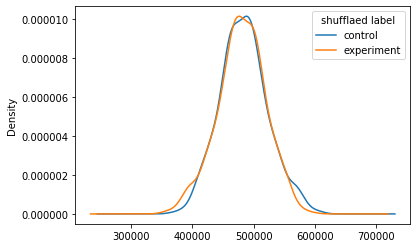

In [37]:
#create a list with shuffling means for each AB-group(shuffle the labels of group field)
gmv=[]
#convert test['group'] to a list to apply random.shuffle()methods
#methods and implementatin as below
#re = test['group'].values.tolist()
#random.shuffle(re)
#print(re)

for i in range(1000):
    random.shuffle(re)
    test['shufflaed label']=re
    gmv_mean=test.groupby('shufflaed label')['gmv'].mean()
    gmv.append(gmv_mean)
    
#transform the list to a Dataframe
gmv=pd.DataFrame(gmv)
print(gmv)

# A kernel Density estimate plot of the boostrap distributiona
gmv.plot(kind='density')


Probablity that difference is greater than observed difference : 0.0


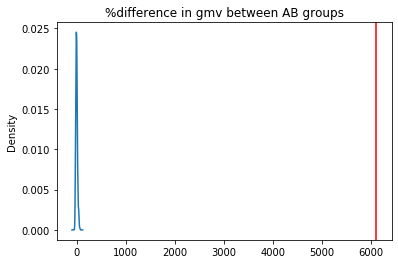

In [38]:
#add a column with the difference between AB group
gmv['diff'] = (gmv.control - gmv.experiment)/gmv.experiment*100

#plot the bootstrap % difference
ax = gmv['diff'].plot(kind = 'density')
ax.set_title('%difference in gmv between AB groups')
ax.axvline(x=p_diff, color= 'r')

#calculate the probablity that 1-day retention is greater when the gate is at level 30
print('Probablity that difference is greater than observed difference :', (gmv['diff']>gmv_diff).mean())
#We reject Ho hypothesis because p-value<0.05, the difference is significant.

### 8 ROI

In [39]:
#calculate the mean difference
ROI_diff=test[test['group']== "control"]['ROI'].mean()-test[test['group']== "experiment"]['ROI'].mean()
ROI_diff

8.68641686777056

shufflaed label     control  experiment
ROI              359.446402  352.601827
ROI              358.773002  353.275227
ROI              361.475473  350.572757
ROI              347.474507  364.573722
ROI              354.394964  357.653266
..                      ...         ...
ROI              349.833154  362.215076
ROI              355.777091  356.271138
ROI              353.180213  358.868017
ROI              357.785933  354.262297
ROI              348.643375  363.404855

[1000 rows x 2 columns]


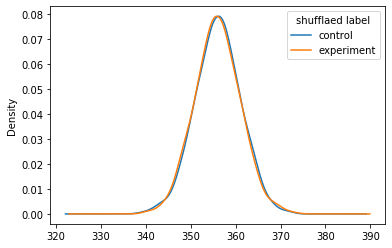

In [41]:
#create a list with shuffling means for each AB-group(shuffle the labels of group field)
ROI=[]
#convert test['group'] to a list to apply random.shuffle()methods
#methods and implementatin as below
#re = test['group'].values.tolist()
#random.shuffle(re)
#print(re)

for i in range(1000):
    random.shuffle(re)
    test['shufflaed label']=re
    ROI_mean=test.groupby('shufflaed label')['ROI'].mean()
    ROI.append(ROI_mean)
    
#transform the list to a Dataframe
ROI=pd.DataFrame(ROI)
print(ROI)

# A kernel Density estimate plot of the boostrap distributiona
ROI.plot(kind='density')



Probablity that difference is greater than observed difference : 0.003


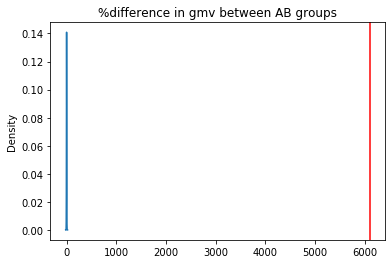

In [42]:
#add a column with the difference between AB group
ROI['diff'] = (ROI.control - ROI.experiment)/ROI.experiment*100

#plot the bootstrap % difference
ax = ROI['diff'].plot(kind = 'density')
ax.set_title('%difference in gmv between AB groups')
ax.axvline(x=p_diff, color= 'r')

#calculate the probablity that 1-day retention is greater when the gate is at level 30
print('Probablity that difference is greater than observed difference :', (ROI['diff']>ROI_diff).mean())
#We reject Ho hypothesis because p-value<0.05, the difference is significant.

## 二、城市运营分析

### 1 数据导入

In [2]:
#导入该城市运营相关数据

city = pd.read_excel('/home/kesci/input/didi4010/city.xlsx')
city.head()

,date,hour,requests,trips,supply hours,average minutes of trips,pETA,aETA,utiliz
0,2013-09-01,11,79,55,42.63,20.43,5.51,7.19,0.479240
1,2013-09-01,12,73,41,36.43,15.53,5.48,8.48,0.426297
2,2013-09-01,13,54,50,23.02,17.76,5.07,8.94,0.771503
3,2013-09-02,11,193,170,64.20,31.47,5.31,6.55,0.490187
4,2013-09-02,12,258,210,80.28,38.68,4.94,6.08,0.481814


In [25]:
#查看数据有无缺失值

city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
date                        90 non-null datetime64[ns]
hour                        90 non-null int64
requests                    90 non-null int64
trips                       90 non-null int64
supply hours                90 non-null float64
average minutes of trips    90 non-null float64
pETA                        90 non-null float64
aETA                        90 non-null float64
utiliz                      90 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 6.4 KB


### 2 数据探索

#### 2.1 单量最多的时间点

In [4]:
req_hour = city.groupby(['hour'],as_index=True).agg({'requests':sum},inplace=True)
req_hour

,requests
hour,
11,6008
12,8530
13,6559


In [6]:
#绘制各时点订单请求柱状图

import matplotlib.pyplot as plt

req_hour.plot(kind='bar')
plt.xticks(rotation=0)

plt.show()

<Figure size 432x288 with 1 Axes>

* 可见，在11、12、13这三个时间点内，12点用户发起订单的需求是最大的，其次是13点，11点。

* **司机运营平台应考虑加大该时点车辆供应**。

#### 2.2 单量最多的日期

In [53]:
req_date = city.groupby(['date'],as_index=True).agg({'requests':sum},inplace=True)
req_date.sort_values('date').head()

,requests
date,
2013-09-01,206
2013-09-02,604
2013-09-03,238
2013-09-04,199
2013-09-05,782


In [57]:
#绘制订单请求数随日期变化的折线图

req_date.plot(kind='line')

plt.show()

<Figure size 432x288 with 1 Axes>

* 单月订单请求数随日期的变化呈周期性变化，我们猜测4个峰值分别对应4个周末，周末用户出行需求较大。

* 经验证发现猜想与数据吻合，因此**司机运营平台应考虑加大周末、节假日的车辆供给**。

#### 2.3 各时段订单完成率

In [5]:
com_hour = city.groupby(['hour'],as_index=False).agg({'requests':sum,'trips':sum},inplace=True)
com_hour['rate']=com_hour['trips']/com_hour['requests']
com_hour

,hour,requests,trips,rate
0,11,6008,4550,0.757324
1,12,8530,5850,0.685815
2,13,6559,3085,0.470346


* 13点订单需求较多，但订单完成率仅47%，说明较多订单没有得到及时相应。

* ** 客运部应重点关注13点订单相应时长**，排查具体原因。

#### 2.4 单月每日订单完成率

In [67]:
com_date = city.groupby(['date'],as_index=True).agg({'requests':sum,'trips':sum},inplace=True)
com_date['rate']=com_date['trips']/com_date['requests']
com_date.sort_values('date').head()

,requests,trips,rate
date,,,
2013-09-01,206,146,0.708738
2013-09-02,604,487,0.806291
2013-09-03,238,83,0.348739
2013-09-04,199,102,0.512563
2013-09-05,782,532,0.680307


In [70]:
#绘制订单完成率随日期变化的折线图

com_date.rate.plot(kind='line')

plt.show()

<Figure size 432x288 with 1 Axes>

* 单月每日订单完成率规律不太明显，但几个谷值基本都出现在周末附近，说明客户出行需求的提升可能导致响应率的降低。

#### 2.5 顾客等待时间

In [77]:
import numpy as np

eta_hour = city.groupby(['hour'],as_index=True).agg({'pETA':np.mean,'aETA':np.mean},inplace=True)
eta_hour

,pETA,aETA
hour,,
11,5.397333,6.611000
12,5.860000,7.253333
13,6.018333,7.732667


In [78]:
#绘制顾客等待时长复合柱状图

eta_hour.plot(kind='bar')

<Figure size 432x288 with 1 Axes>

* 以上可见，无论哪个时点，用户实际等待时长均明显大于用户预计等待时长。

* 各时点用户等待时长差异不明显，但13点最高。

* **客运部一方面应提升用户预计等待时长的准确性，另一方面优化平台派单逻辑等。**

#### 2.6 司机在忙率

In [7]:
city['busy'] = city['supply hours']*city['utiliz']
city.head()

,date,hour,requests,trips,supply hours,average minutes of trips,pETA,aETA,utiliz,busy
0,2013-09-01,11,79,55,42.63,20.43,5.51,7.19,0.479240,20.43
1,2013-09-01,12,73,41,36.43,15.53,5.48,8.48,0.426297,15.53
2,2013-09-01,13,54,50,23.02,17.76,5.07,8.94,0.771503,17.76
3,2013-09-02,11,193,170,64.20,31.47,5.31,6.55,0.490187,31.47
4,2013-09-02,12,258,210,80.28,38.68,4.94,6.08,0.481814,38.68


In [8]:
busy_hour = city.groupby(['hour'],as_index=False).agg({'supply hours':sum,'busy':sum})
busy_hour['utiliz'] = busy_hour['busy']/busy_hour['supply hours']
busy_hour

,hour,supply hours,busy,utiliz
0,11,1660.01,768.51,0.462955
1,12,1818.03,1115.28,0.613455
2,13,1274.60,730.83,0.573380


* 12点司机在忙总时长最长，在忙率也最高，用户订单请求也最多，说明车辆总数偏少。

#### 2.7 订单时长

In [10]:
trip_min = city.groupby(['hour'],as_index=False).agg({'average minutes of trips':np.mean})
trip_min

,hour,average minutes of trips
0,11,25.617
1,12,37.176
2,13,24.361


* 12点用户订单需求较多，同时订单时长最长，说明这个时间点是一个非常重要的时间点。

In [9]:
supply_hour = city.groupby(['hour'],as_index=False).agg({'supply hours':np.mean})
supply_hour

,hour,supply hours
0,11,55.333667
1,12,60.601000
2,13,42.486667


* 13点订单量也较大，此时点司机服务时长较短。

* **为优化用户出行体验，司机运营平台可联合客运部可考虑此时段尽量分配总服务时长较长的司机来接单（经验较为丰富）。**

### 3 后续思考方向

* 提升顾客预计等待时长预测准确度（需要历史数据进行预测）

* 加大车辆投入（分车辆不同等级来看，因此可能需要车辆相关信息表）

* 优化用户体验（需要客诉相关数据）

* 优化平台派单逻辑（需要订单的位置相关数据）

* 个性化需求（需要用户属性、及其他行为数据）